/var/folders/58/wmz93cpn03z4sny570d7zrq00000gn/T/ipykernel_1346/3604379420.py:51: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  y = np.array([[speed_x], [speed_y], [speed_w]], dtype=float)


Text(0, 0.5, 'Omega')

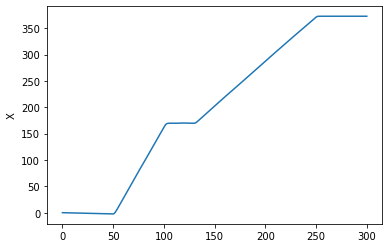

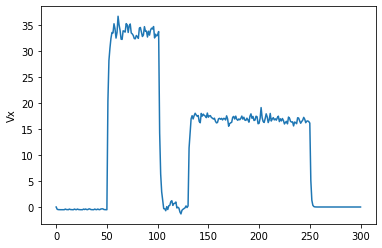

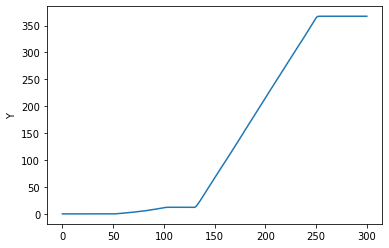

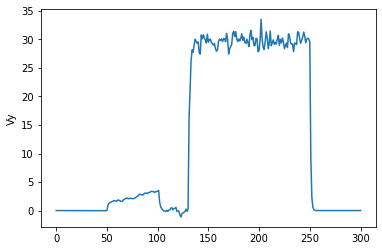

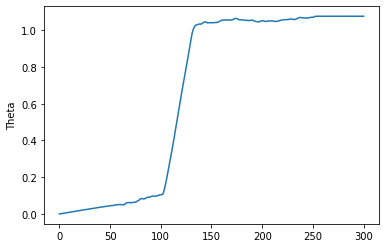

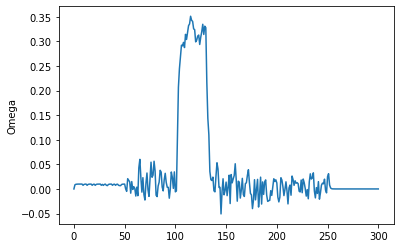

In [67]:
import tdmclient.notebook
await tdmclient.notebook.start()
import matplotlib.pyplot as plt
import time
import numpy as np

j = 0 #Auxiliary variable
Ts = 0.1 #Sampling time
theta = 0.0 #rad
r = 15.0 #mm
l = 80.0 #mm

vision = 0 #Set to 1 if position from camera available

# State-space model
N=6
A = np.array([[1, Ts, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, Ts, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, Ts], [0, 0, 0, 0, 0, 1]])
#State-space model (with acceleration, C to be modified as well)
#A = np.array([[1, Ts, Ts*Ts/2.0, 0, 0, 0, 0, 0], [0, 1, Ts, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, Ts, Ts*Ts/2.0, 0, 0], [0, 0, 0, 0, 1, Ts, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, Ts], [0, 0, 0, 0, 0, 0, 0, 1]])
#N = 8

Q = 6.5*np.identity(N) #Disturbance covariance matrix (TO BE MEASURED)

speed_conv_factor = 0.347 #Speed from thymio speed to mm/s (to confirm)
rot_conv_factor = 0.0066

#Defining measurements
if vision==1:
    M = 6
    C = np.array([[1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0], [0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1]])
else:
    M = 3
    C = np.array([[0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1]])
    
R = 3*np.identity(M) #Measurement covariance matrix

P_est_prev = 10 * np.identity(N) #Initial P_est
x_est_prev = np.array([[0], [0], [0], [0], [0], [0]]) #Initial position
x_est_range = x_est_prev #Matrix storing all values from the beginning


def kalman_filter(speed_x, speed_y, speed_w ,x_est_prev, P_est_prev, vision=0, pos_x=0.0, pos=0.0, theta=0):
    
    x_est_a_priori = np.dot(A, x_est_prev); #A priori estimate
    P_est_a_priori = np.dot(A, np.dot(P_est_prev, A.T)) + Q
    
    ## Update measurements         
    if vision==1:
        y = np.array([[pos_x], [pos_y], [theta], [speed_x], [speed_y], [speed_w]], dtype=float)
    else:
        y = np.array([[speed_x], [speed_y], [speed_w]], dtype=float)

    i = y - np.dot(C, x_est_a_priori) #Measurement residual
    S = np.dot(C, np.dot(P_est_a_priori, C.T)) + R
    K = np.dot(P_est_a_priori, np.dot(C.T, np.linalg.inv(S))) #Kalman gain
    x_est = x_est_a_priori + np.dot(K,i) #A posteriori estimate
    P_est = P_est_a_priori - np.dot(K,np.dot(C, P_est_a_priori))
     
    return x_est, P_est

@tdmclient.notebook.sync_var
def obtain_values(theta, left, right, s=0):
    #accel_x = 0.00981/23*acc[1]*np.cos(theta)+0.00981/23*acc[0]*np.sin(theta)
    #accel_y = 0.00981/23*acc[1]*np.sin(theta)-0.00981/23*acc[0]*np.cos(theta)
    speed_x = (speed_conv_factor*(motor_left_speed+motor_right_speed)/2.0) * np.cos(theta)
    #speed_x = speed_conv_factor*(motor_left_speed+motor_right_speed)/2.0
    speed_y = (speed_conv_factor*(motor_left_speed+motor_right_speed)/2.0) * np.sin(theta)
    speed_w = rot_conv_factor*(motor_right_speed-motor_left_speed)/(2.0)
    global motor_left_target, motor_right_target
    if s == 1:
        motor_left_target = left
        motor_right_target = right
    return speed_x, speed_y, speed_w

x_no_filter = np.array([0])
x_no_filter_range = np.array([0])

for i in range(300):
    j = j+1
    if j==1:
        speed_x, speed_y, speed_w = obtain_values(theta, 0, 0, 1)
    elif j==50:
        speed_x, speed_y, speed_w = obtain_values(theta, 100, 100, 1)
    elif j==100:
        speed_x, speed_y, speed_w = obtain_values(theta, -50, 50, 1)
    elif j==130:
        speed_x, speed_y, speed_w = obtain_values(theta, 100, 100, 1)
    elif j==250:
        speed_x, speed_y, speed_w = obtain_values(theta, 0, 0, 1)
    else:
        speed_x, speed_y, speed_w = obtain_values(theta, 0, 0, 0)
    x_est, P_est = kalman_filter(speed_x, speed_y, speed_w, x_est_prev, P_est_prev, vision)
    theta = x_est[4]
    x_est_range = np.concatenate((x_est_range, x_est), axis=1)
    x_no_filter[0] = x_no_filter[0]+Ts*speed_x
    x_no_filter_range = np.concatenate((x_no_filter_range, x_no_filter))
    x_est_prev = x_est
    P_est_prev = P_est
    time.sleep(Ts)
 

plt.figure("X")
plt.plot(x_est_range[0])
plt.ylabel("X")

plt.figure("Vx")
plt.plot(x_est_range[1], label="Vx_value")
plt.ylabel("Vx")

plt.figure("Y")
plt.plot(x_est_range[2], label="Y_value")
plt.ylabel("Y")

plt.figure("Vy")
plt.plot(x_est_range[3], label="Vy_value")
plt.ylabel("Vy")

plt.figure("Theta")
plt.plot(x_est_range[4], label="Theta")
plt.ylabel("Theta")

plt.figure("Omega")
plt.plot(x_est_range[5], label="Omega")
plt.ylabel("Omega")



In [64]:
motor_left_target=-0
motor_right_target=0

In [66]:
await tdmclient.notebook.stop()